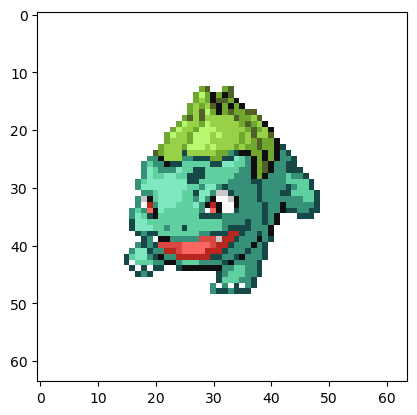

In [1]:
from PIL import Image
import torch
from torchvision import transforms
from torch import nn
import numpy as np
from load_dataset import load_dataset, plot_image
from tqdm import tqdm
from random import randint
from matplotlib import pyplot as plt

torch.set_printoptions(sci_mode=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pimages = load_dataset().to(device)
pimages.shape # [3, 386, 3, 64, 64]

plot_image(pimages[0, 0, :, :, :])

In [2]:
#https://www.mdpi.com/2072-4292/11/9/1015/pdf
#@torch.compile
def ssim_loss(pred, target):
    mean_pred = torch.mean(pred, dim=(2, 3))
    mean_target = torch.mean(target, dim=(2, 3))

    var_pred = torch.var(pred, dim=(2, 3))
    var_target = torch.var(target, dim=(2, 3))

    cov = torch.mean(pred * target, dim=(2, 3)) - mean_pred * mean_target

    c1 = 0.01 ** 2
    c2 = 0.03 ** 2

    ssim = (2 * mean_pred * mean_target + c1) * (2 * cov + c2) 
    ssim /= (mean_pred ** 2 + mean_target ** 2 + c1) * (var_pred + var_target + c2)

    return (1 - ssim) / 2

class PConv(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, bias=False, residual=False):
        super().__init__()
        self.residual = residual
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding='same', bias=bias),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
        )

    def forward(self, x):
        if self.residual:
            return self.conv(x) + x
        return self.conv(x)

class TConv(nn.Module):
    def __init__(self, in_c, out_c, bias=False):
        super().__init__()
        self.tconv = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1,
                               bias=bias),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
        )               
    
    def forward(self, x):
        return self.tconv(x)

In [3]:
Channels = 4

class PaletteDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.patch_encoder = nn.Linear(8 * 8 * 3, 1024)

        self.encoder = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=1024, nhead=32, dim_feedforward=1024, batch_first=True),
                num_layers = 2
            )
        
        self.decode_image = nn.Sequential(
            PConv(64, 32, bias=True),
            
            PConv(32, 32, residual=True),
            PConv(32, 32, residual=True),

            TConv(32, 16),
            PConv(16, 16, residual=True),
            PConv(16, 16, residual=True),

            PConv(16, 3, bias=True, kernel_size=1),
        )
    
    def forward(self, x):
        
        # x.shape = [bs, 3, 64, 64]
        x = x.permute(0, 2, 3, 1)
        x = x.unfold(1, 8, 8).unfold(2, 8, 8).flatten(1, 2)
        # x.shape = [bs, 16, 3, 16, 16]
        
        # sample 8 patches on each image on the batch
        #for i in range(x.shape[0]):
        #    index = torch.randperm(x.shape[1])
        #    x[i, :, :, :, :] = x[i, index, :, :, :]
        #x = x[:, 0:8, :, :, :]

        x = x.flatten(2, 4)

        # x.shape = [bs, 8, 16 * 16 * 3]
        x = self.patch_encoder(x)
        x = self.encoder(x)

        # x.shape = [bs, 8, 1024]
        x = x.unflatten(2, (32, 32))
        x = self.decode_image(x)

        return torch.sigmoid(x) * 2 - 1

  0%|          | 0/4001 [00:00<?, ?it/s]

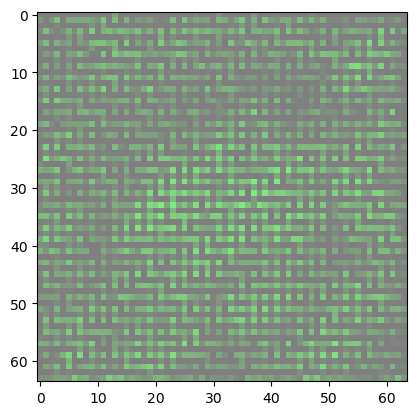

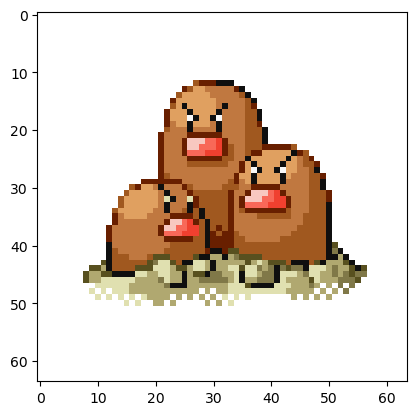

0.56495792:   2%|▏         | 100/4001 [00:10<06:40,  9.75it/s]

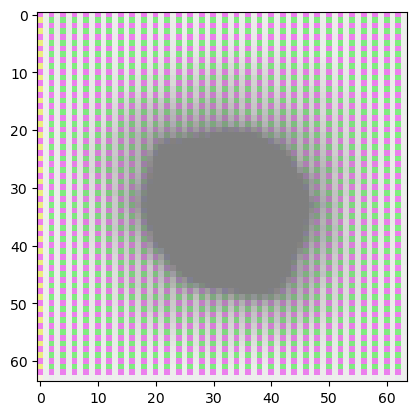

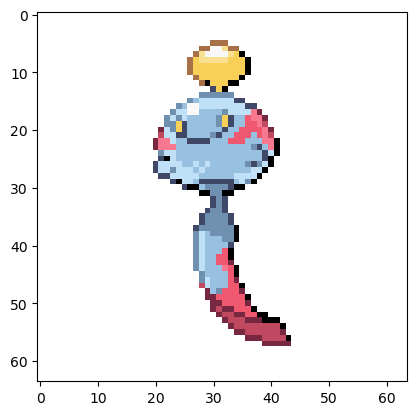

0.55996835:   5%|▍         | 199/4001 [00:20<06:09, 10.30it/s]

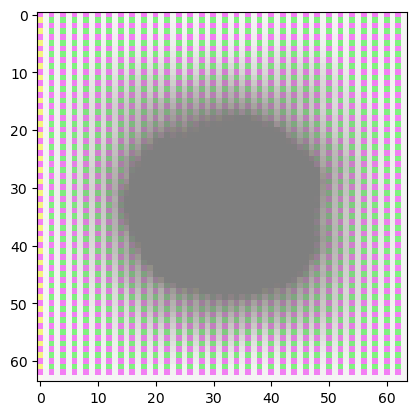

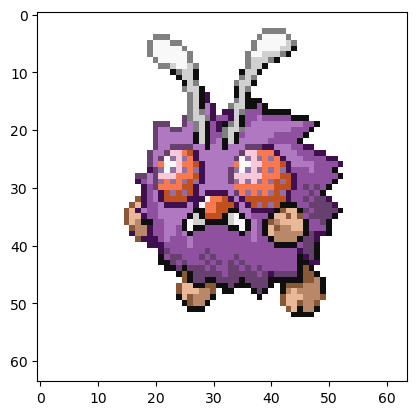

0.39878976:   7%|▋         | 300/4001 [00:31<06:16,  9.84it/s]

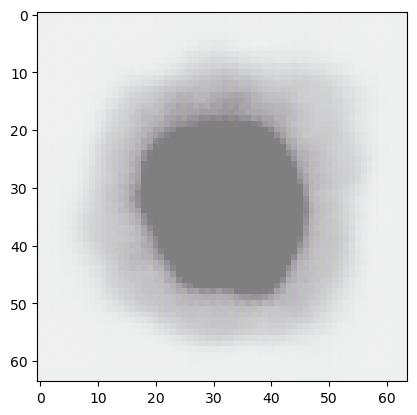

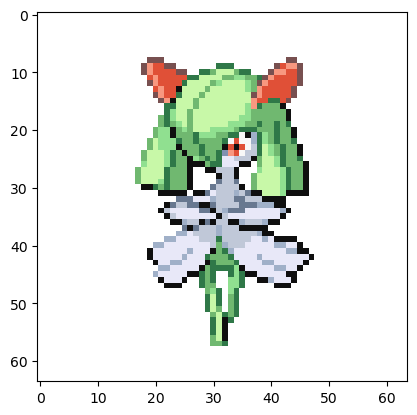

0.36293152:  10%|▉         | 400/4001 [00:42<06:36,  9.08it/s]

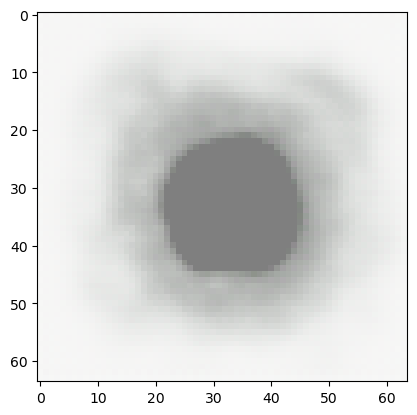

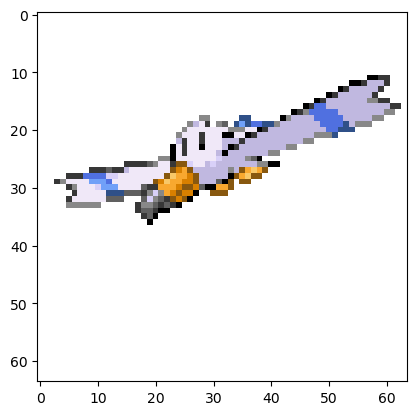

0.49744511:  12%|█▏        | 500/4001 [00:53<06:22,  9.15it/s]

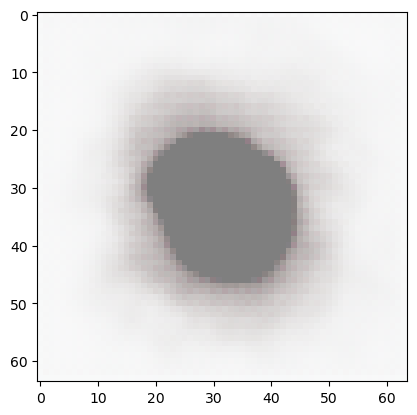

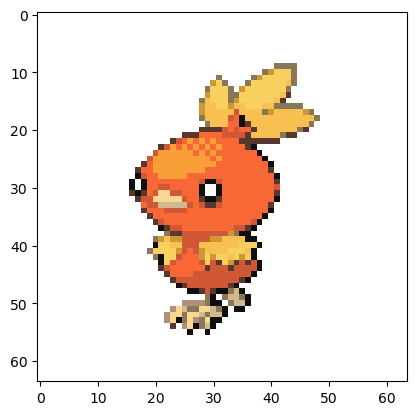

0.33360797:  15%|█▍        | 600/4001 [01:03<05:56,  9.54it/s]

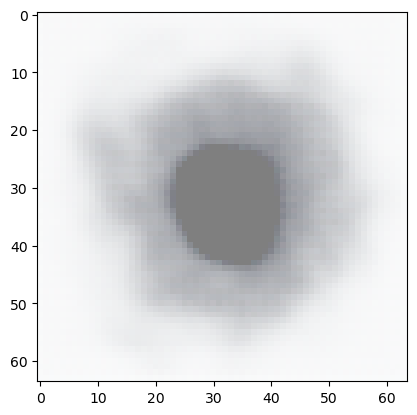

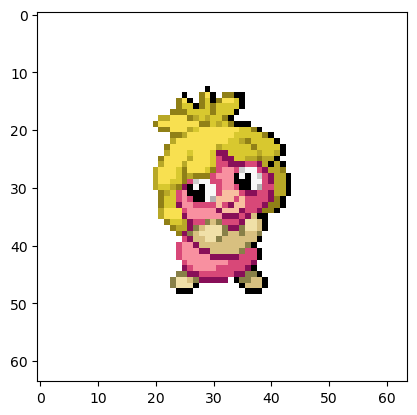

0.30367434:  17%|█▋        | 700/4001 [01:14<05:59,  9.19it/s]

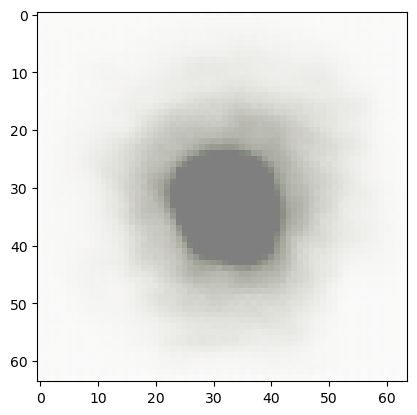

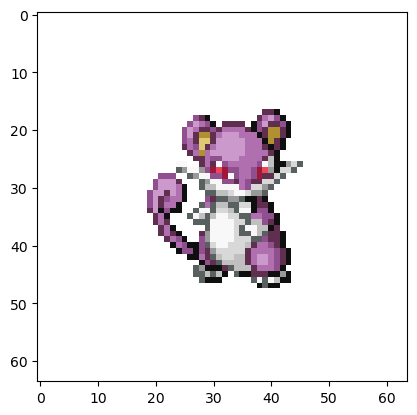

0.34317142:  20%|█▉        | 799/4001 [01:25<05:14, 10.18it/s]

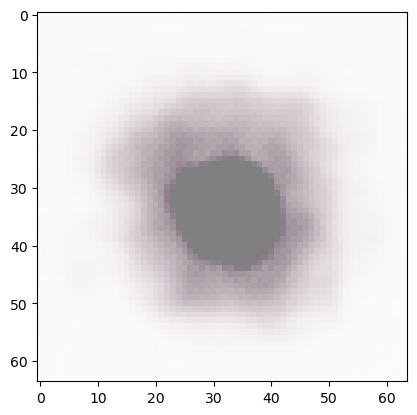

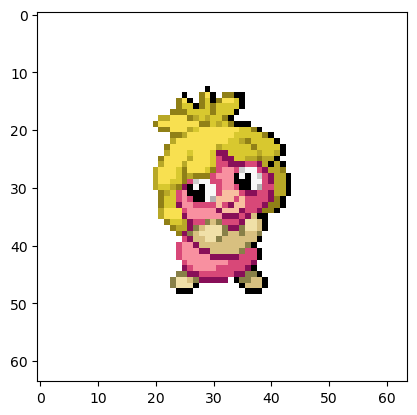

0.40083784:  22%|██▏       | 900/4001 [01:35<05:21,  9.64it/s]

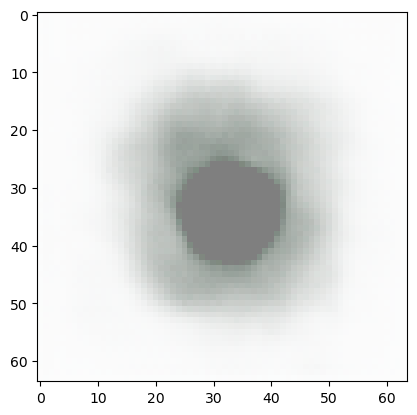

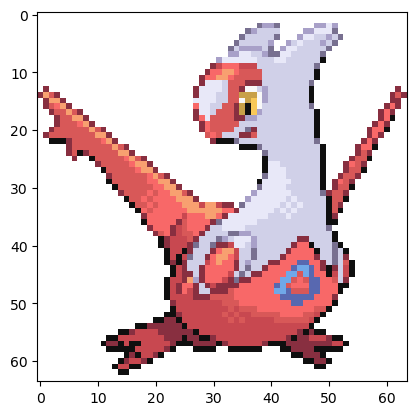

0.38665938:  24%|██▍       | 956/4001 [01:41<05:23,  9.40it/s]


KeyboardInterrupt: 

In [4]:
bs = 15

model = PaletteDecoder().to(device)
loss_func = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

pbar = tqdm(range(4001))
def closure():
    optimizer.zero_grad()
    
    # Sample a batch of images
    source = randint(0, 2)
    batch = torch.randperm(385)[:bs]
    x0 = pimages[source, batch]

    # Shuffle the color channels
    color = torch.randperm(3)
    x0 = x0[:, color, :, :]
    # x0 dim = [bs, 3, 64, 64]

    image_rgb = model(x0)

    loss = loss_func(image_rgb, x0) + 0.5 * ssim_loss(image_rgb, x0).mean()

    pbar.set_description(f"%.8f" % loss, refresh=False)

    loss.backward()
    return loss


 
model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 100 == 0:
        with torch.no_grad():
            model.eval()
            
            source = randint(0, 2)
            batch = torch.randperm(385)[:1]
            x0 = pimages[source, batch]

            image_rgb = model(x0)

            plot_image(image_rgb[0])
            plot_image(x0[0])

            model.train()